# Import Libraries

In [ ]:
import numpy as np
import os
import pandas as pd
import pickle
import csv
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, BatchNormalization,MaxPooling1D, Dropout, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
import gc
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Reshape, Conv1D, GlobalAveragePooling1D, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_model(model , checkpoint_filepath):
  model.load_weights(os.path.join(checkpoint_filepath, os.listdir(checkpoint_filepath)[-2]))
  return model

# Function to load data from pickle file
def load_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
def plot_history(file_path):
  # Read the CSV file into a DataFrame
  df = pd.read_csv(file_path)

  grouped_df = df.groupby('epoch').last().reset_index()
  # Extract data for plotting
  epoch = df['epoch']
  acc = df['accuracy']
  val_acc = df['val_accuracy']
  loss = df['loss']
  val_loss = df['val_loss']

  # Plot the accuracy and validation accuracy
  plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
  plt.subplot(1, 2, 1)  # Create subplot for accuracy
  plt.plot(epoch, acc, label='Accuracy', color='blue')
  plt.plot(epoch, val_acc, label='Validation Accuracy', color='green')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot the loss and validation loss
  plt.subplot(1, 2, 2)  # Create subplot for loss
  plt.plot(epoch, loss, label='Loss', color='red')
  plt.plot(epoch, val_loss, label='Validation Loss', color='purple')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

In [ ]:
batch_size = 32

# Predict labels for each aspect with batch processing
def predict_labels(model, x_data):
    predicted_probs = []
    for i in range(0, len(x_data), batch_size):
        batch_x = x_data[i:i + batch_size]
        batch_probs = model.predict(np.array(batch_x))
        predicted_probs.extend(batch_probs)
    return np.array(predicted_probs)

def results(model, x_test, y_test, X_test, title):
    assert tf.test.is_gpu_available()
    sentiment_mapping = {1: 'Neutral', 0: 'Negative', 2: 'Positive'}
    predicted_probs = predict_labels(model, x_test)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test[:9800], predicted_labels)

    # Compute precision, recall, and f1 score for each class
    precision = precision_score(y_test[:9800], predicted_labels, average=None)
    recall = recall_score(y_test[:9800], predicted_labels, average=None)
    f1 = f1_score(y_test[:9800], predicted_labels, average=None)

    # Create a table
    table = PrettyTable()
    table.field_names = ["Sentiment Class", "Precision", "Recall", "F1 Score"]

    # Populate the table with data
    for i in range(len(precision)):
        sentiment_class = sentiment_mapping[i]
        table.add_row([sentiment_class, precision[i], recall[i], f1[i]])

    # Print the table
    print(table)
    del predicted_probs
    del predicted_labels

    print(f"\nOverall Accuracy: {overall_accuracy:.4f}\n")

    scores_df = pd.DataFrame({
        'Sentiment Class': ['Negative', 'Neutral', 'Positive'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Overall Accuracy': [overall_accuracy,overall_accuracy,overall_accuracy]  # Add overall accuracy to DataFrame
    })
    scores_df.to_csv(f"/content/drive/MyDrive/ASC/results/models/{title}_scores.csv", index=False)


    print('\n\n__________________________________________________________________________________\n\n')

    # Separate data based on the aspect
    y_true_aspect_1, y_true_aspect_2 = [], []
    x_true_aspect_1, x_true_aspect_2 = [], []
    index = 0
    tt = X_test['aspect'].tolist()

    y_test = y_test.tolist()
    for id in range(9800):  # Check if the index is within bounds
        if tt[id] == 'the teacher':
            x_true_aspect_1.append(x_test[id])
            y_true_aspect_1.append(y_test[id])
        else:
            x_true_aspect_2.append(x_test[id])
            y_true_aspect_2.append(y_test[id])

    predicted_probs_teacher = predict_labels(model, x_true_aspect_1)
    predicted_labels_teacher = np.argmax(predicted_probs_teacher, axis=1)
    del predicted_probs_teacher

    # Predict labels for 'the course' aspect
    predicted_probs_course = predict_labels(model, x_true_aspect_2)
    predicted_labels_course = np.argmax(predicted_probs_course, axis=1)
    del predicted_probs_course
    # Print overall accuracy

    # Function to calculate and print scores
    def print_scores(y_true, predicted_labels, aspect_name):
        precision = precision_score(y_true, predicted_labels, average=None)
        recall = recall_score(y_true, predicted_labels, average=None)
        f1 = f1_score(y_true, predicted_labels, average=None)
        aspect_accuracy = accuracy_score(y_true, predicted_labels)

        table = PrettyTable()
        table.field_names = [f"{aspect_name} Class", "Precision", "Recall", "F1 Score"]

        for i in range(len(precision)):
            table.add_row([f'Class {i}', precision[i], recall[i], f1[i]])

        aspect_scores_df = pd.DataFrame({
        'Class': ['Negative', 'Neutral', 'Positive'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Aspect Accuracy': [aspect_accuracy,aspect_accuracy,aspect_accuracy]
        })
        # Save scores to CSV file with the specified title and aspect name
        aspect_scores_df.to_csv(f"/content/drive/MyDrive/ASC/results/models/{title}_{aspect_name}_scores.csv", index=False)

        # Print accuracy for each aspect
        print(f"\nAccuracy for '{aspect_name}' aspect: {aspect_accuracy:.4f}")
        print(table)

    # Print scores for 'the teacher' aspect
    print("--------------Scores for 'the teacher' aspect:--------------")
    print_scores(y_true_aspect_1, predicted_labels_teacher, 'the teacher')
    del predicted_labels_teacher
    # Print scores for 'the course' aspect
    print("\n--------------Scores for 'the course' aspect:--------------")
    print_scores(y_true_aspect_2, predicted_labels_course, 'the course')
    del predicted_labels_course


# Baseline Algorithms

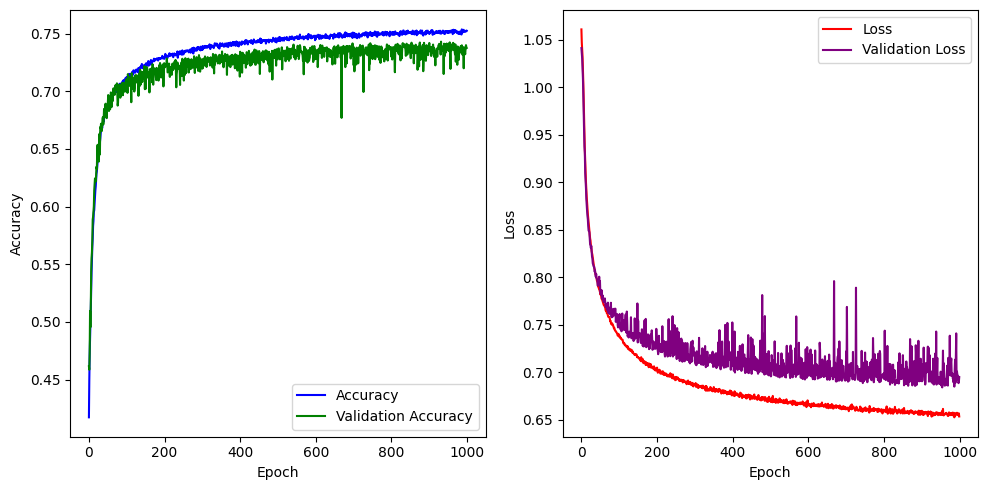



__________________________________________________________________________________


1/1 [==============================] - 0s 39ms/step
+-----------------+--------------------+---------------------+--------------------+
| Sentiment Class |     Precision      |        Recall       |      F1 Score      |
+-----------------+--------------------+---------------------+--------------------+
|     Negative    | 0.4648257725180802 | 0.44353826850690087 | 0.4539325842696629 |
|     Neutral     | 0.4577259475218659 |  0.5266849649283318 | 0.4897901304594442 |
|     Positive    | 0.6495812395309882 |  0.5817581758175817 | 0.6138018360240581 |
+-----------------+--------------------+---------------------+--------------------+

Overall Accuracy: 0.5184



__________________________________________________________________________________


1/1 [==============================] - 0s 17ms/step
--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.4908
+--

In [ ]:
x_test = load_from_pickle("/content/drive/MyDrive/ASC/dataset/test.pkl")
X_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/X_test.pkl')
y_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/y_test.pkl')
basic = [i for i in range(3)]
enc = OneHotEncoder()
enc.fit(np.array(basic).reshape(-1,1))
y_enc = enc.transform(y_test[:9800].values.reshape(-1, 1))
y_enc = [y_enc[j].toarray() for j in range(9800)]


model = Sequential([
    Dense(4, input_shape=(600,), activation='linear'),  # Linear layer
    Dense(3, activation='softmax')  # Softmax layer for classification
])

def perplexity(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

loss_function = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_function, metrics=[ 'accuracy', perplexity])

model = load_model(model , '/content/drive/MyDrive/ASC/results/models/baseline/')

file_path = '/content/drive/MyDrive/ASC/results/models/baseline/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test , 'Baseline')

# Deep Learning Algorithms

**Read Data**

In [ ]:
x_test = load_from_pickle("/content/drive/MyDrive/ASC/dataset/final_test_bert.pkl")
X_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/X_test.pkl')
y_test = load_from_pickle('/content/drive/MyDrive/ASC/dataset/y_test.pkl')
basic = [i for i in range(3)]
enc = OneHotEncoder()
enc.fit(np.array(basic).reshape(-1,1))
y_enc = enc.transform(y_test[:9800].values.reshape(-1, 1))
y_enc = [y_enc[j].toarray() for j in range(9800)]



---

# EXP 1 :

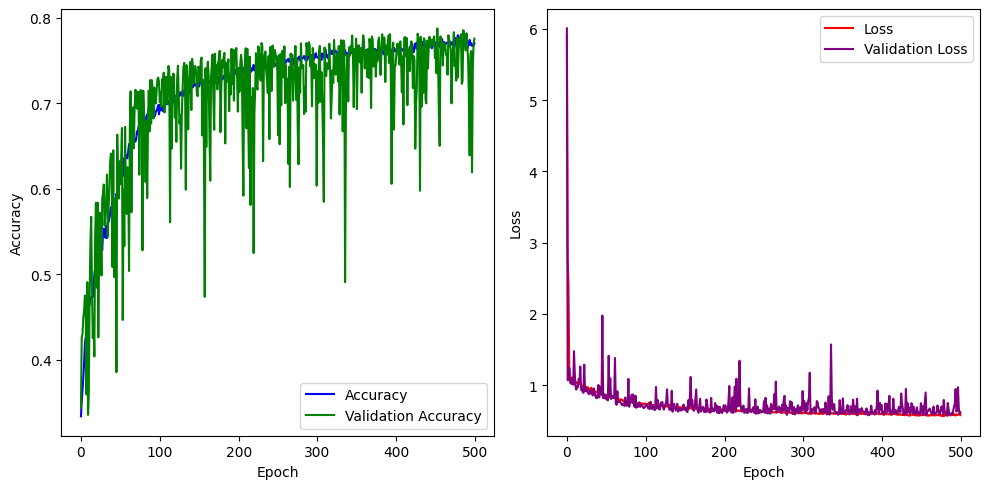



__________________________________________________________________________________


1/1 [==============================] - 0s 75ms/step
+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    | 0.7348269994327851 | 0.8127352572145545 | 0.7718200774501043 |
|     Neutral     | 0.8137824235385211 | 0.6410491003354681 | 0.7171613783691574 |
|     Positive    | 0.7702519642373341 | 0.8529852985298529 | 0.809510250569476  |
+-----------------+--------------------+--------------------+--------------------+

Overall Accuracy: 0.7690



__________________________________________________________________________________


1/1 [==============================] - 0s 34ms/step
--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.6239
+---------

In [ ]:
model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(4):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])


#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA2/')[-2])
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/exp1/', 'model_weights_epoch453_val_acc0.7878.h5'))

file_path = '/content/drive/MyDrive/ASC/results/models/exp1/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test, 'exp1')



---


#EXP 2:

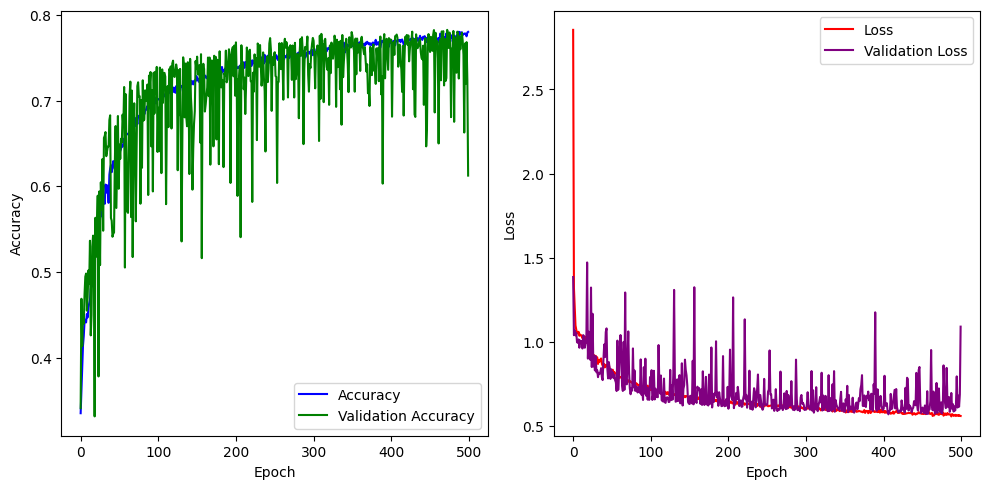



__________________________________________________________________________________


1/1 [==============================] - 0s 86ms/step
+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    | 0.7332589285714286 | 0.8243412797992472 | 0.7761370348493799 |
|     Neutral     | 0.8091014269186271 | 0.6398292162244587 | 0.7145776566757494 |
|     Positive    | 0.7764283742754623 | 0.843984398439844  | 0.8087981598619896 |
+-----------------+--------------------+--------------------+--------------------+

Overall Accuracy: 0.7693



__________________________________________________________________________________


1/1 [==============================] - 0s 47ms/step
--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.6216
+---------

In [ ]:
model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(6):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])



#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA2/')[-2])
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/exp2/', 'model_weights_epoch473_val_acc0.7826.h5'))

file_path = '/content/drive/MyDrive/ASC/results/models/exp2/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test, 'exp2')




---

#EXP 3:

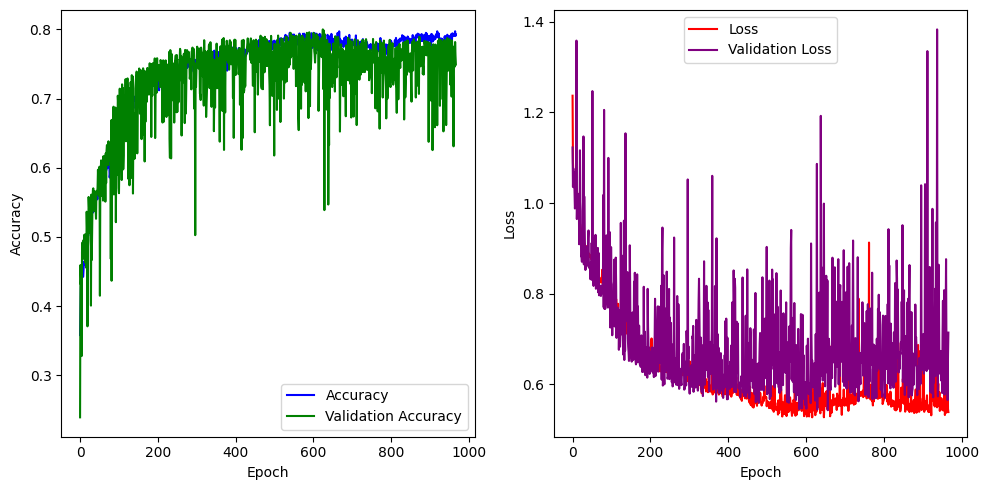



__________________________________________________________________________________


1/1 [==============================] - 0s 112ms/step
+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    | 0.7736938031591738 | 0.7989335006273526 | 0.7861111111111111 |
|     Neutral     | 0.793526405451448  | 0.7102775236352546 | 0.7495976826520759 |
|     Positive    | 0.7886929750909599 | 0.8454845484548454 | 0.8161019403417318 |
+-----------------+--------------------+--------------------+--------------------+

Overall Accuracy: 0.7851



__________________________________________________________________________________


1/1 [==============================] - 0s 36ms/step
--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.6399
+--------

In [ ]:
model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(10):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


loss_function = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)


model.compile( loss=loss_function, metrics=['accuracy'])


#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA2/')[-2])
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/exp3/', 'z_model_weights_epoch123_val_acc0.7958.h5'))

file_path = '/content/drive/MyDrive/ASC/results/models/exp3/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test , 'exp3')




---

# DLA1 :


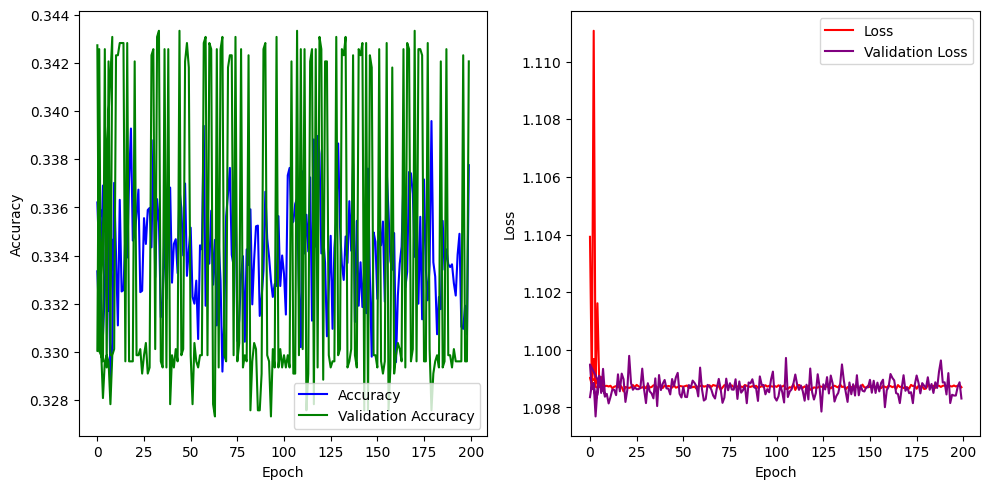



__________________________________________________________________________________


307/307 [==============================] - 5s 14ms/step
+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    | 0.8068109484404837 | 0.7951693851944793 | 0.8009478672985781 |
|     Neutral     | 0.7978652434956638 | 0.7294906983836535 | 0.7621475227019278 |
|     Positive    | 0.7863387978142077 | 0.8634863486348635 | 0.823108823108823  |
+-----------------+--------------------+--------------------+--------------------+


__________________________________________________________________________________


293/293 [==============================] - 4s 14ms/step

Overall Accuracy: 0.7964

--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.6216
+-

In [ ]:
model = Sequential([
    Dense(4, input_shape=(393816,), activation='linear'),
])

for _ in range(10):
    model.add(Dense(units=64, activation='relu'))

model.add(Dense(3, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA2/')[-2])
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/DLA2/', 'model_weights_epoch120.h5'))

file_path = '/content/drive/MyDrive/ASC/results/models/DLA1/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test)



---


# DLA2 :

In [ ]:
from keras import backend as K

# ... (your code)

# Clear Keras session to release memory
K.clear_session()

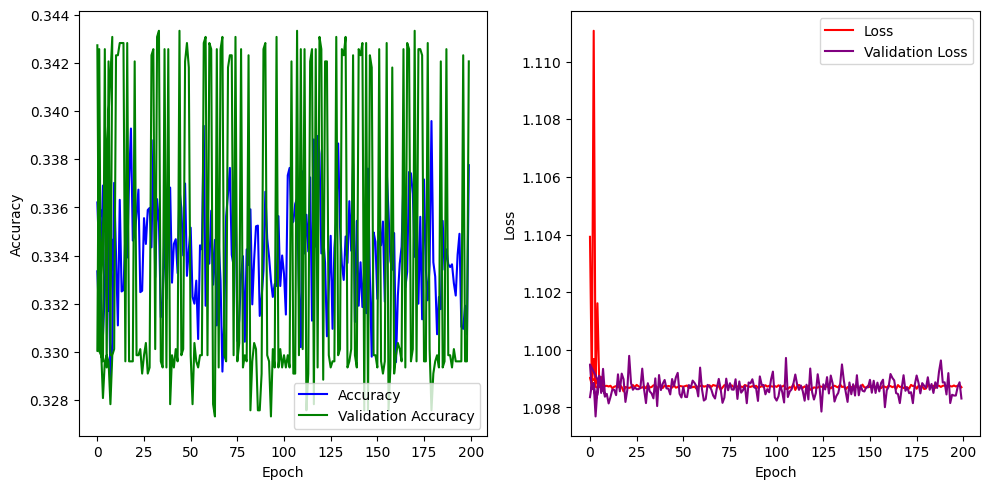



__________________________________________________________________________________


307/307 [==============================] - 5s 14ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    |        0.0         |        0.0         |        0.0         |
|     Neutral     | 0.4273927392739274 | 0.3159499847514486 | 0.3633175521655269 |
|     Positive    | 0.4107917570498915 | 0.9090909090909091 | 0.5658791670557475 |
+-----------------+--------------------+--------------------+--------------------+


__________________________________________________________________________________


293/293 [==============================] - 4s 14ms/step

Overall Accuracy: 0.4149

--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.2294
+-------------------+---------------------+--------------------+---------------------+
| the teacher Class |      Precision      |       Recall  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = Sequential()

model.add(Dense(64, input_shape=(393816,), activation='linear'))

for _ in range(8):
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))

# Reduced final layer units based on problem requirements
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA3/')[-2])
check = os.listdir('/content/drive/MyDrive/ASC/results/models/DLA3/')[-2]
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/DLA3/', check))


file_path = '/content/drive/MyDrive/ASC/results/models/DLA1/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test)



---

# DLA3 :

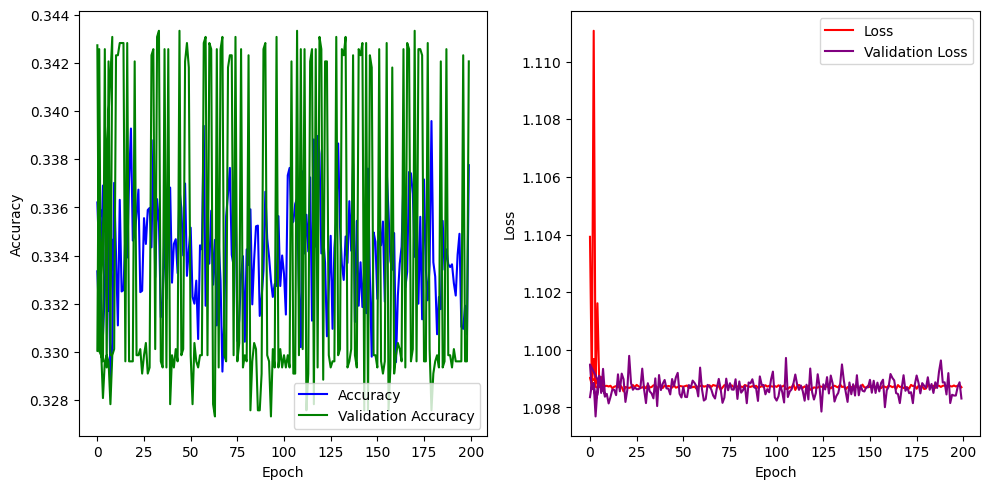



__________________________________________________________________________________


307/307 [==============================] - 7s 15ms/step
+-----------------+--------------------+--------------------+--------------------+
| Sentiment Class |     Precision      |       Recall       |      F1 Score      |
+-----------------+--------------------+--------------------+--------------------+
|     Negative    | 0.6475910980679873 | 0.8306148055207027 | 0.7277724336952041 |
|     Neutral     | 0.9056603773584906 | 0.4830741079597438 | 0.630071599045346  |
|     Positive    | 0.7412922766279657 | 0.8811881188118812 | 0.8052090472926662 |
+-----------------+--------------------+--------------------+--------------------+


__________________________________________________________________________________


293/293 [==============================] - 4s 15ms/step

Overall Accuracy: 0.7315

--------------Scores for 'the teacher' aspect:--------------

Accuracy for 'the teacher' aspect: 0.6560
+-

In [ ]:
model = Sequential()

# Input Layer
model.add(Dense(4, input_shape=(393816,), activation='linear'))

# Hidden Layers
model.add(Dense(units=128, activation='relu'))
model.add(Reshape((128, 1)))  # Add Reshape layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(GlobalAveragePooling1D())

for _ in range(5):  # Reduced the number of dropout layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))

model.add(Dense(units=4, activation='relu'))

# Output Layer
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model = load_model(model , os.listdir('/content/drive/MyDrive/ASC/results/models/DLA1/')[-2])

check = os.listdir('/content/drive/MyDrive/ASC/results/models/bi-directional')[-1]
model.load_weights(os.path.join('/content/drive/MyDrive/ASC/results/models/bi-directional/', check))

file_path = '/content/drive/MyDrive/ASC/results/models/DLA1/history1.csv'
plot_history(file_path)

print('\n\n__________________________________________________________________________________\n\n')

results(model, x_test, y_test, X_test)